In [1]:
# ---------------- processing Raman files exported from Peakfit

    # - This code was developed in close collaboration with Valeria Fonseca Díaz and Marco Dalla Vecchia, and would not exist without their help!
    
# --- import modules

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#from matplotlib.collections import LineCollection


# --- set working directories

base_dir = "_DATA/"

In [2]:
# --- function to import data from spectrum and peak files and create a combined dataframe

def spectrum_data(spectrum_file):
    
    # --- PART 1: import spectrum data from input file and create a spectrum dataframe

        # --- set file name to be processed
    current_mineral = spectrum_file.replace(".dat", "").replace(".txt", "")

            # --- get input file and save as a spectrum dataframe

    df_spectrum = pd.read_csv(base_dir+"spectra/"+spectrum_file, header=None, skiprows=1, sep='\s+',
                             names=['XY', 'X Value', 'Y Value', 'Y Predict', 'Residual', 'Residual%', '90% Confidence', 'Limits', '90% Prediction', 'Limits2', 'Weights'])

    df_spectrum = df_spectrum.drop(columns=['XY']) 
        
        # --- add file information
    df_spectrum["file"] = current_mineral
    
        # --- separate file information into relavant acquisition parameters
#     df_spectrum[['sample','grating','laser','edge',
#                  'filter','objective','vis','lwd',
#                  'pinhole','acquisition','set']]=df_spectrum["file"].str.split(pat='_', expand=True)
    
#     df_spectrum = df_spectrum[['file','sample','grating','laser',
#                                'filter','objective','pinhole','acquisition',
#                                'wv','intensity','stddev','model','residuals','wtresiduals']]
        
       

    # --- PART 2: get corresponding peak information from input file 
         
    separator = " "

        # --- get lines from processed peak file

    current_peak = open(base_dir+"peaks/"+current_mineral+'_peaks.txt', "r")
    original_current_lines = current_peak.readlines()
    current_lines = []

    for line in original_current_lines:
        partial_lines = line.split("  ")
        while "" in partial_lines:
            partial_lines.remove("")
        str_line = ""
        for item in partial_lines:
            str_line = str_line + item.replace(" ","")+ separator
        current_lines.append(str_line)

        # --- get values from lines

    counter = 0

    for line in current_lines:
        if "r^2CoefDet" in line:
            break
        counter+=1

    r2 = current_lines[counter+1].split(separator)[0]

        # --- get total number of peaks from last peak entry, at the end of peak file

    counter = 0

    for line in current_lines[::-1]:
        if "Peak" in line:
            peak_line = line
            break

    total_peaks = peak_line.split(separator)
    peak_number = int(total_peaks[0].replace("Peak",""))
    peak_number

        # --- get positions of overall tables

    counter = 0
    peaks_tables_loc = []

    for line in current_lines:
        if "Peak"+separator in line:
            peaks_tables_loc.append(counter)
        counter += 1

        # --- grab data per peak for each table

    peaks_dict = {}

    for ii in range(peak_number):
        peaks_dict[str(ii+1)] = {}

    for line_counter in peaks_tables_loc:    
        current_attributes = current_lines[line_counter].split(separator)

        for iii in range(line_counter+1,(line_counter+peak_number+1)):
            split_line = current_lines[iii].split(separator)

            kk=0

            for attribute in current_attributes: 

                peaks_dict[str(iii-(line_counter))][attribute.replace("\n","")] = split_line[kk].replace("\n","")
                kk+=1

            # --- final peak table

    df_peaks = pd.DataFrame.from_dict(peaks_dict, orient="index")

    df_peaks.drop("",axis=1,inplace=True)

    df_peaks["r2"] = r2
    df_peaks["mineral"] = current_mineral

    #return df_peaks

          

    # --- PART 3: combine peak parameters with spectrum dataframe

    df_spectrum_peaks = df_spectrum.copy()

        # --- create tuples that will receive each peak parameter

    wv_range = np.array(df_spectrum["X Value"])
    current_center_range = np.zeros(df_spectrum.shape[0])
    current_height_range = np.zeros(df_spectrum.shape[0])
    current_fwhm_range = np.zeros(df_spectrum.shape[0])
    current_a0_range = np.zeros(df_spectrum.shape[0])
    current_a1_range = np.zeros(df_spectrum.shape[0])
    current_a2_range = np.zeros(df_spectrum.shape[0])
    current_a3_range = np.zeros(df_spectrum.shape[0])
    

        # --- copy peak parameters from peak dataframe


    peak_parameters = df_peaks[['Center','Amplitude','FWHM','a0','a1','a2','a3']].astype(float) 
    # here a float conversion is needed because df_peaks has only strings, and np.where condition will compare wv_range numbers
    
   
        # --- loop through peaks in peak dataframe to copy and assign values to tuples created

    for peak, value in peak_parameters['Center'].iteritems():    
        current_center_range[np.where(wv_range>=value)[0][0]] = value
        current_height_range[np.where(wv_range>=value)[0][0]] = peak_parameters['Amplitude'][peak]
        current_fwhm_range[np.where(wv_range>=value)[0][0]] = peak_parameters['FWHM'][peak]
        current_a0_range[np.where(wv_range>=value)[0][0]] = peak_parameters['a0'][peak]
        current_a1_range[np.where(wv_range>=value)[0][0]] = peak_parameters['a1'][peak]
        current_a2_range[np.where(wv_range>=value)[0][0]] = peak_parameters['a2'][peak]
        current_a3_range[np.where(wv_range>=value)[0][0]] = peak_parameters['a3'][peak]
              
        
        # --- assign tuples with peak parameters as columns in the spectra dataframe

    df_spectrum_peaks["center"] = current_center_range
    df_spectrum_peaks["height"] = current_height_range
    df_spectrum_peaks["FWHM"] = current_fwhm_range
    df_spectrum_peaks["G/L"] = current_a3_range
    df_spectrum_peaks["a0"] = current_a0_range
    df_spectrum_peaks["a1"] = current_a1_range
    df_spectrum_peaks["a2"] = current_a2_range
    df_spectrum_peaks["a3"] = current_a3_range
    df_spectrum_peaks["R2"] = r2

    
        # --- Convert 'a' parameters to numeric for later calculations
    df_spectrum_peaks['a0'] = pd.to_numeric(df_spectrum_peaks['a0'])
    df_spectrum_peaks['a1'] = pd.to_numeric(df_spectrum_peaks['a1'])
    df_spectrum_peaks['a2'] = pd.to_numeric(df_spectrum_peaks['a2'])
    df_spectrum_peaks['a3'] = pd.to_numeric(df_spectrum_peaks['a3'])

    #df_spectrum_peaks.to_csv('C:/Users/u0125722/Documents/Python_Scripts/output/figures/'+current_mineral+".csv",index = None)
    return df_spectrum_peaks





# --- function to plot curves with the Gaussian+Lorentzian sum profile

def gauss_lor_sum(x, a_0, a_1, a_2, a_3):
    return (a_0*(((((a_3*np.sqrt(np.log(2)))/(a_2*np.sqrt(np.pi)))*(np.exp(-4*np.log(2)*(((x-a_1)/a_2)**2))))+((1-a_3)/(np.pi*a_2*(1+(4*(((x-a_1)/a_2)**2))))))/
                 (((a_3*np.sqrt(np.log(2)))/(a_2*np.sqrt(np.pi)))+((1-a_3)/(np.pi*a_2)))))


In [3]:
# --- get list of files

spectra_files = sorted(os.listdir(base_dir+"spectra"))

peak_files = sorted(os.listdir(base_dir+"peaks"))

print(spectra_files,
      "\n",len(spectra_files),
      "\n\n",
    peak_files,
      "\n",len(peak_files),)

['Anatase__R060277-3__Raman__514__0__depolarized__Raman_Data_Processed__14967.dat', 'Rutile__R050417-3__Raman__514__0__depolarized__Raman_Data_Processed__27357.dat', 'bu02a-area1-top-rutile-opaq2_150 (500nm)_633nm_edge_50%_x50_vis_lwd_h100um_10sx2.dat', 'bu04-ore1_150 (500nm)_532nm_edge_10%_x50_vis_lwd_h30um_20sx2.dat', 'bu04-ore2-bright_150 (500nm)_532nm_edge_10%_x10_vis_h30um_40sx2.dat', 'bu04-ore2-mid_gray_150 (500nm)_532nm_edge_10%_x50_vis_h30um_40sx2.dat', 'bu19ts(1)-ore1-core_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2.dat', 'bu19ts(1)-ore2-rim_150 (500nm)_532nm_edge_10%_x100_vis_swd_h30um_30sx2.dat', 'bu19ts(2)-ore2-core_150 (500nm)_532nm_edge_10%_x100_vis_h30um_30sx2.dat', 'bu19ts(2)-ore2-core_1800 (450-850nm)_532nm_edge_10%_x100_vis_h30um_60sx2.dat', 'bu19ts(2)-ore2-rim_150 (500nm)_532nm_edge_10%_x100_vis_h30um_30sx2.dat', 'bu19ts(2)-ore2-rim_1800 (450-850nm)_532nm_edge_10%_x100_vis_h30um_60sx2.dat', 'bu19ts-coltan3-core_150 (500nm)_633nm_edge_10%_x100_vis_h30um_10sx2.

In [52]:
    # --- select one file from the spectra dataset to work with

#ff = 1
ff = spectra_files.index('bu04-ore2-mid_gray_150 (500nm)_532nm_edge_10%_x50_vis_h30um_40sx2.dat')

print(peak_files[ff])
print(spectra_files[ff])

df_spectrum_peaks = spectrum_data(spectra_files[ff])

df_spectrum_peaks

bu04-ore2-mid_gray_150 (500nm)_532nm_edge_10%_x50_vis_h30um_40sx2_peaks.txt
bu04-ore2-mid_gray_150 (500nm)_532nm_edge_10%_x50_vis_h30um_40sx2.dat


,X Value,Y Value,Y Predict,Residual,Residual%,90% Confidence,Limits,90% Prediction,Limits2,Weights,file,center,height,FWHM,G/L,a0,a1,a2,a3,R2
0,103.924,0.000000,5.838974,-5.838974,0.000000,4.119355,7.558594,-14.885430,26.563383,1,bu04-ore2-mid_gray_150 (500nm)_532nm_edge_10%_...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99927396
1,108.546,0.840321,7.745808,-6.905487,-821.767400,5.224756,10.266860,-13.060430,28.552050,1,bu04-ore2-mid_gray_150 (500nm)_532nm_edge_10%_...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99927396
2,113.165,7.274486,12.107088,-4.832603,-66.432220,6.276624,17.937552,-9.353068,33.567245,1,bu04-ore2-mid_gray_150 (500nm)_532nm_edge_10%_...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99927396
3,117.782,29.651306,26.928509,2.722797,9.182722,13.195929,40.661089,2.126740,51.730278,1,bu04-ore2-mid_gray_150 (500nm)_532nm_edge_10%_...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99927396
4,122.394,73.072128,70.917072,2.155056,2.949217,54.861774,86.972369,44.757627,97.076517,1,bu04-ore2-mid_gray_150 (500nm)_532nm_edge_10%_...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99927396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,980.417,-2.895153,10.853072,-13.748220,474.870370,8.814100,12.892043,-9.900275,31.606419,1,bu04-ore2-mid_gray_150 (500nm)_532nm_edge_10%_...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99927396
200,984.613,-1.806940,10.128912,-11.935850,660.556210,8.231222,12.026602,-10.611030,30.868855,1,bu04-ore2-mid_gray_150 (500nm)_532nm_edge_10%_...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99927396
201,988.807,-1.714472,9.476407,-11.190880,652.730330,7.705776,11.247038,-11.252300,30.205110,1,bu04-ore2-mid_gray_150 (500nm)_532nm_edge_10%_...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99927396
202,993.000,-0.736169,8.886078,-9.622247,1307.069900,7.230009,10.542146,-11.833150,29.605309,1,bu04-ore2-mid_gray_150 (500nm)_532nm_edge_10%_...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99927396


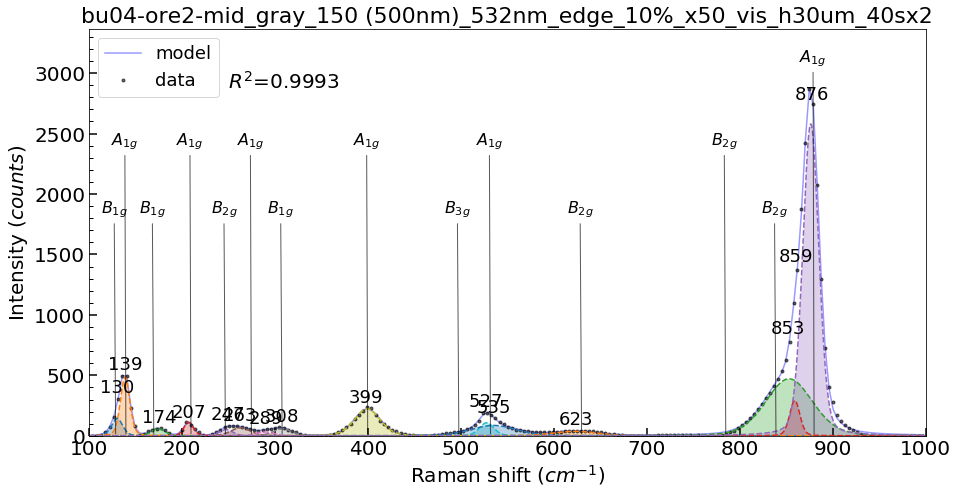

In [54]:
# --- make plot of single spectrum file

    # - set start and end for the plot x axis 

start = 100 
end = 1000

fig, ax = plt.subplots(figsize=(15,7.5))

    # --- RUTILE - add specific annotations for normal modes in the spectrum

# plt.annotate("$B_{1g}$",xy=(143, 0), xytext=(126, np.percentile(df_spectrum_peaks["Y Value"], 90)),
#               arrowprops=dict(arrowstyle="-",
#                               edgecolor = "black",
#                               linewidth=1,
#                               alpha=0.65), size = 16)

# plt.annotate("$E_{g}$",xy=(447, 0), 
#              xytext=(437, np.percentile(df_spectrum_peaks["Y Value"], 100)+np.percentile(df_spectrum_peaks["Y Value"], 80)),
#               arrowprops=dict(arrowstyle="-",
#                               edgecolor = "black",
#                               linewidth=1,
#                               alpha=0.65), size = 16)

# plt.annotate("$A_{1g}$",xy=(612, 0), 
#              xytext=(597, np.percentile(df_spectrum_peaks["Y Value"], 100)+np.percentile(df_spectrum_peaks["Y Value"], 80)),
#               arrowprops=dict(arrowstyle="-",
#                               edgecolor = "black",
#                               linewidth=1,
#                               alpha=0.65), size = 16)

# plt.annotate("$B_{2g}$",xy=(826, 0), xytext=(810, np.percentile(df_spectrum_peaks["Y Value"], 90)),
#               arrowprops=dict(arrowstyle="-",
#                               edgecolor = "black",
#                               linewidth=1,
#                               alpha=0.65), size = 16)

# plt.text(240, np.percentile(df_spectrum_peaks["Y Value"], 91), 
#             "Second order \nphonons",horizontalalignment='center',fontsize=16)

    # --- COLTAN - add specific annotations for normal modes in the spectrum

plt.annotate("$A_{1g}$",xy=(880, 0), 
             xytext=(864, np.percentile(df_spectrum_peaks["Y Value"], 100)+np.percentile(df_spectrum_peaks["Y Value"], 88)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$B_{2g}$",xy=(630, 0), 
             xytext=(614, np.percentile(df_spectrum_peaks["Y Value"], 98)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$A_{1g}$",xy=(532, 0), 
             xytext=(516, np.percentile(df_spectrum_peaks["Y Value"], 99)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$A_{1g}$",xy=(400, 0), 
             xytext=(384, np.percentile(df_spectrum_peaks["Y Value"], 99)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$A_{1g}$",xy=(275, 0), 
             xytext=(259, np.percentile(df_spectrum_peaks["Y Value"], 99)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$B_{1g}$",xy=(129, 0), 
             xytext=(113, np.percentile(df_spectrum_peaks["Y Value"], 98)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$A_{1g}$",xy=(140, 0), 
             xytext=(124, np.percentile(df_spectrum_peaks["Y Value"], 99)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$A_{1g}$",xy=(210, 0), 
             xytext=(194, np.percentile(df_spectrum_peaks["Y Value"], 99)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$B_{2g}$",xy=(785, 0), 
             xytext=(769, np.percentile(df_spectrum_peaks["Y Value"], 99)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$B_{2g}$",xy=(839, 0), 
             xytext=(823, np.percentile(df_spectrum_peaks["Y Value"], 98)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$B_{1g}$",xy=(170, 0), 
             xytext=(154, np.percentile(df_spectrum_peaks["Y Value"], 98)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$B_{2g}$",xy=(247, 0), 
             xytext=(231, np.percentile(df_spectrum_peaks["Y Value"], 98)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$B_{1g}$",xy=(308, 0), 
             xytext=(292, np.percentile(df_spectrum_peaks["Y Value"], 98)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

plt.annotate("$B_{3g}$",xy=(498, 0), 
             xytext=(482, np.percentile(df_spectrum_peaks["Y Value"], 98)),
              arrowprops=dict(arrowstyle="-",
                              edgecolor = "black",
                              linewidth=1,
                              alpha=0.65), size = 16)

    # - plot the raw spectrum line (measured data) and the modelled spectrum (after peak fitting)

plt.plot(df_spectrum_peaks["X Value"],df_spectrum_peaks["Y Predict"],'b-', label='model', alpha=0.4)
plt.plot(df_spectrum_peaks["X Value"],df_spectrum_peaks["Y Value"],'k.', label='data', alpha=0.6)


    # - plot the modelled center value (Raman shift) of peaks above the curve.
            # plotting the FWHM is also possible by using the commented section   
    
for ii in range(df_spectrum_peaks.shape[0]):
    if start < df_spectrum_peaks.iloc[ii]["center"] < end:
        text = str(int(df_spectrum_peaks.iloc[ii]["center"]))
        plt.text(df_spectrum_peaks.iloc[ii]["X Value"]-20,
                 df_spectrum_peaks.iloc[ii]["Y Predict"]+np.percentile(df_spectrum_peaks["Y Predict"], 60),
                 text,fontsize=18)
#         if np.percentile(df_spectrum_peaks.iloc[ii]["height"], 50) > df_spectrum_peaks.iloc[ii]["center"]:
#             text = str(int(df_spectrum_peaks.iloc[ii]["FWHM"]))
#             plt.text(df_spectrum_peaks.iloc[ii]["wv"]-15,df_spectrum_peaks.iloc[ii]["intensity"]+10,text,fontsize=18)
   
    # - get positions of peak data inside the overall file
    
counter = 0
peak_lines_loc = []

for value in df_spectrum_peaks['center']:
    if value > 0:
        peak_lines_loc.append(counter)
    counter += 1

    
    # --- add modelled peaks to plot
    
x = np.arange(start,end)

for peak in peak_lines_loc:
    a_0 = df_spectrum_peaks['height'][peak]
    a_1 = df_spectrum_peaks['a1'][peak]
    a_2 = df_spectrum_peaks['a2'][peak]
    a_3 = df_spectrum_peaks['a3'][peak]
    y = gauss_lor_sum(x, a_0, a_1, a_2, a_3)
    plt.plot(x,y,ls='--')
    ax.fill_between(x, y.min(),y, alpha=0.3)
        
        
    # --- adjust plot parameters

plt.legend(loc='best',fontsize=18)    
    
plt.xlabel("Raman shift ($cm^{-1}$)",fontsize=20)
plt.xlim([start,end])
plt.ylabel("Intensity ($counts$)",fontsize=20)
plt.ylim([-5,np.percentile(df_spectrum_peaks["Y Value"], 100)+np.percentile(df_spectrum_peaks["Y Value"], 94)])

ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(axis='both', which='major',labelsize=20,direction='in',width=1.5,length=8)
ax.tick_params(axis='both', which='minor',direction='in',width=1,length=4)

plt.title(df_spectrum_peaks.iloc[0]["file"],horizontalalignment='center',fontsize=22)

plt.text(start+150, np.percentile(df_spectrum_peaks["Y Value"], 100), 
            "$R^2$="+str(round(float(df_spectrum_peaks.iloc[0]["R2"]),4)),fontsize=20)


        
plt.savefig('C:/Users/u0125722/Documents/Python_Scripts/output/figures/'+df_spectrum_peaks.iloc[0]["file"]+'_peakfit.pdf')
plt.show()

In [ ]:
# # Takes list of lines, where each line is a sequence of coordinates
# l1 = [(140, 0), (140, np.percentile(df_spectrum_peaks["Y Value"], 90))]
# l2 = [(440, 0), (440, np.percentile(df_spectrum_peaks["Y Value"]+500, 100))]
# l3 = [(610, 0), (610, np.percentile(df_spectrum_peaks["Y Value"]+500, 100))]
# l4 = [(810, 0), (810, np.percentile(df_spectrum_peaks["Y Value"], 90))]
# lc = LineCollection([l1, l2, l3, l4], color=["black"], linewidth=1)

# plt.gca().add_collection(lc)